<a href="https://colab.research.google.com/github/divyalaldinani/Deep-Learning-in-TensorFlow/blob/main/06_transfer_learning_scaling_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Creating models on all 101 food categories: 10% training data

In [ ]:
!wget https://raw.githubusercontent.com/divyalaldinani/Deep-Learning-in-TensorFlow/refs/heads/main/extras/helper_functions.py

--2025-01-24 13:31:50--  https://raw.githubusercontent.com/divyalaldinani/Deep-Learning-in-TensorFlow/refs/heads/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4090 (4.0K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]   3.99K  --.-KB/s    in 0s      

2025-01-24 13:31:50 (96.6 MB/s) - ‘helper_functions.py’ saved [4090/4090]



In [ ]:
from helper_functions import prep_and_load_file, plot_confusion_matrix, pred_and_plot, plot_loss_curves, unzip_folder, view_random_image, walk_through_directory, view_random_image_and_augmented, create_tensorboard_callback1

In [ ]:
!nvidia-smi

Fri Jan 24 13:37:18 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Downloading and preprocessing the data

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

--2025-01-24 13:37:46--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.207, 172.253.117.207, 142.250.99.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   123MB/s    in 16s     

2025-01-24 13:38:03 (98.5 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [ ]:
unzip_folder('101_food_classes_10_percent.zip')

In [ ]:
train_dir = '101_food_classes_10_percent/train/'
test_dir = '101_food_classes_10_percent/test/'

In [ ]:
walk_through_directory('101_food_classes_10_percent')

2 directories and 0 files in 101_food_classes_10_percent
101 directories and 0 files in 101_food_classes_10_percent/test
0 directories and 250 files in 101_food_classes_10_percent/test/baby_back_ribs
0 directories and 250 files in 101_food_classes_10_percent/test/poutine
0 directories and 250 files in 101_food_classes_10_percent/test/escargots
0 directories and 250 files in 101_food_classes_10_percent/test/chicken_quesadilla
0 directories and 250 files in 101_food_classes_10_percent/test/carrot_cake
0 directories and 250 files in 101_food_classes_10_percent/test/deviled_eggs
0 directories and 250 files in 101_food_classes_10_percent/test/hamburger
0 directories and 250 files in 101_food_classes_10_percent/test/sashimi
0 directories and 250 files in 101_food_classes_10_percent/test/peking_duck
0 directories and 250 files in 101_food_classes_10_percent/test/ice_cream
0 directories and 250 files in 101_food_classes_10_percent/test/caesar_salad
0 directories and 250 files in 101_food_class

### Creating input data pipelines

In [ ]:
import tensorflow as tf

IMG_SIZE = (224, 224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                            label_mode='categorical',
                                                                            image_size=IMG_SIZE,
                                                                            seed = 42) # convert images to this dim

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode='categorical',
                                                                image_size=IMG_SIZE,
                                                                shuffle = False) # defaults to True, set to False as shuffling doesnt help and you want to test on same data all times, to get a better criteria for comparision


Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


### Training a Model on 101 Categories for 10% of training data

In [ ]:
checkpoint_path = 'model_0_checkpoints_weights/ckpt/ceckpoint.weights.h5'
# to save model's weights for further use

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                         save_weights_only=True,
                                         monitor='val_accuracy', # save the model that gets best val accuracy
                                         save_best_only=True)


In [ ]:

# from tensorflow.keras.layers.experimental import preprocessing


In [ ]:
base_model = tf.keras.applications.MobileNetV3Small(include_top=False)

base_model.trainable = False

from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomWidth(0.2),
    layers.RandomHeight(0.2),
    layers.RandomZoom(0.2),
    layers.RandomRotation(0.2)
], name = 'data_augmentation')

inputs = layers.Input(shape=(224, 224, 3), name = 'input_layer')
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D(name='global_avg_pooling')(x)
outputs = layers.Dense(len(train_data_10_percent.class_names), activation='softmax', name = 'output_layer')(x)
model = tf.keras.Model(inputs, outputs)

/usr/local/lib/python3.11/dist-packages/keras/src/applications/mobilenet_v3.py:452: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

history_0 = model.fit(train_data_10_percent,
                      validation_data=test_data,
                      epochs=5,
                      callbacks=[checkpoint_callback])

Epoch 1/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 147s 579ms/step - accuracy: 0.0568 - loss: 4.5090 - val_accuracy: 0.2763 - val_loss: 3.1216
Epoch 2/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 72s 306ms/step - accuracy: 0.2851 - loss: 3.1159 - val_accuracy: 0.3748 - val_loss: 2.5906
Epoch 3/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 78s 289ms/step - accuracy: 0.3720 - loss: 2.7058 - val_accuracy: 0.4101 - val_loss: 2.3656
Epoch 4/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 66s 281ms/step - accuracy: 0.4021 - loss: 2.4799 - val_accuracy: 0.4377 - val_loss: 2.2294
Epoch 5/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 64s 271ms/step - accuracy: 0.4346 - loss: 2.3267 - val_accuracy: 0.4627 - val_loss: 2.1350


In [ ]:
inputs

<KerasTensor shape=(None, 224, 224, 3), dtype=float32, sparse=False, name=input_layer>

In [ ]:
model.evaluate(test_data)

790/790 ━━━━━━━━━━━━━━━━━━━━ 46s 59ms/step - accuracy: 0.4295 - loss: 2.3004


[2.1350464820861816, 0.4626534581184387]

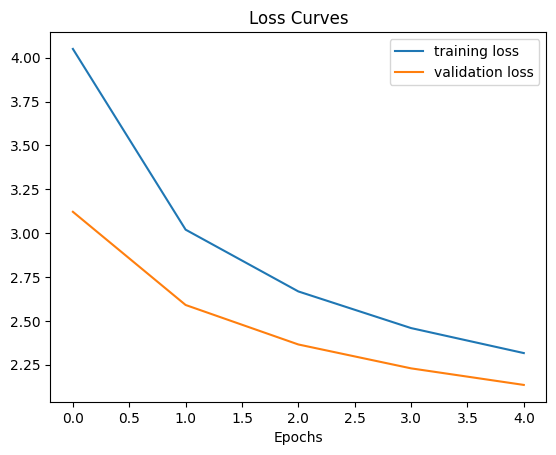

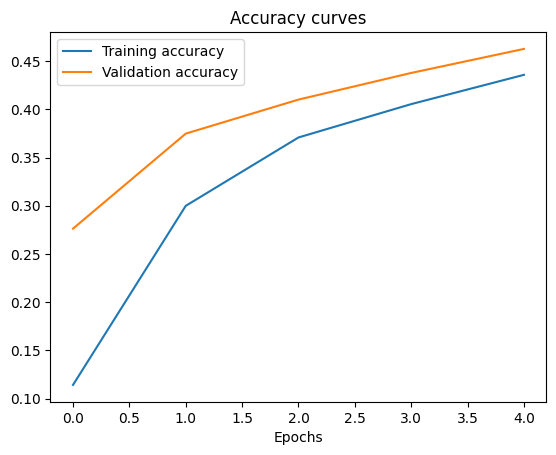

In [ ]:
plot_loss_curves(history_0)

#### Fine-tuning

In [ ]:
# Initially,
# base_model = tf.keras.applications.MobileNetV3Small(include_top=False)

# base_model.trainable = False

base_model.trainable=True
for layer in base_model.layers:
    print(f"{layer.name} {layer.trainable}")

input_layer_8 True
rescaling_4 True
conv True
conv_bn True
activation_72 True
expanded_conv_depthwise_pad True
expanded_conv_depthwise True
expanded_conv_depthwise_bn True
re_lu_56 True
expanded_conv_squeeze_excite_avg_pool True
expanded_conv_squeeze_excite_conv True
expanded_conv_squeeze_excite_relu True
expanded_conv_squeeze_excite_conv_1 True
re_lu_57 True
expanded_conv_squeeze_excite_mul True
expanded_conv_project True
expanded_conv_project_bn True
expanded_conv_1_expand True
expanded_conv_1_expand_bn True
re_lu_58 True
expanded_conv_1_depthwise_pad True
expanded_conv_1_depthwise True
expanded_conv_1_depthwise_bn True
re_lu_59 True
expanded_conv_1_project True
expanded_conv_1_project_bn True
expanded_conv_2_expand True
expanded_conv_2_expand_bn True
re_lu_60 True
expanded_conv_2_depthwise True
expanded_conv_2_depthwise_bn True
re_lu_61 True
expanded_conv_2_project True
expanded_conv_2_project_bn True
expanded_conv_2_add True
expanded_conv_3_expand True
expanded_conv_3_expand_bn Tru

In [ ]:
# only train/unfreeze last 5 layers(towards output)
for layer in base_model.layers[:-5]:
    layer.trainable = False

for layer in base_model.layers:
    print(f"Layer: {layer} Trainable? : {layer.trainable}")

Layer: <InputLayer name=input_layer_8, built=True> Trainable? : False
Layer: <Rescaling name=rescaling_4, built=True> Trainable? : False
Layer: <Conv2D name=conv, built=True> Trainable? : False
Layer: <BatchNormalization name=conv_bn, built=True> Trainable? : False
Layer: <Activation name=activation_72, built=True> Trainable? : False
Layer: <ZeroPadding2D name=expanded_conv_depthwise_pad, built=True> Trainable? : False
Layer: <DepthwiseConv2D name=expanded_conv_depthwise, built=True> Trainable? : False
Layer: <BatchNormalization name=expanded_conv_depthwise_bn, built=True> Trainable? : False
Layer: <ReLU name=re_lu_56, built=True> Trainable? : False
Layer: <GlobalAveragePooling2D name=expanded_conv_squeeze_excite_avg_pool, built=True> Trainable? : False
Layer: <Conv2D name=expanded_conv_squeeze_excite_conv, built=True> Trainable? : False
Layer: <ReLU name=expanded_conv_squeeze_excite_relu, built=True> Trainable? : False
Layer: <Conv2D name=expanded_conv_squeeze_excite_conv_1, built=Tru

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

model.load_weights(checkpoint_path)
history_1 = model.fit(train_data_10_percent,
          validation_data=test_data,
          epochs=5)

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


237/237 ━━━━━━━━━━━━━━━━━━━━ 72s 273ms/step - accuracy: 0.4168 - loss: 2.3932 - val_accuracy: 0.4500 - val_loss: 2.1743
Epoch 2/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 83s 279ms/step - accuracy: 0.4824 - loss: 2.0505 - val_accuracy: 0.4897 - val_loss: 1.9850
Epoch 3/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 81s 275ms/step - accuracy: 0.5058 - loss: 1.9122 - val_accuracy: 0.4956 - val_loss: 1.9550
Epoch 4/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 77s 257ms/step - accuracy: 0.5226 - loss: 1.8428 - val_accuracy: 0.5095 - val_loss: 1.9068
Epoch 5/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 83s 262ms/step - accuracy: 0.5530 - loss: 1.7254 - val_accuracy: 0.5105 - val_loss: 1.8991


In [ ]:
model.evaluate(test_data)

790/790 ━━━━━━━━━━━━━━━━━━━━ 47s 59ms/step - accuracy: 0.4624 - loss: 2.1037


[1.8990875482559204, 0.5104950666427612]

In [ ]:
import matplotlib.pyplot as plt
def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two TensorFlow model History objects.

    Args:
      original_history: History object from original model (before new_history)
      new_history: History object from continued model training (after original_history)
      initial_epochs: Number of epochs in original_history (new_history plot starts from here)
    """

    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()


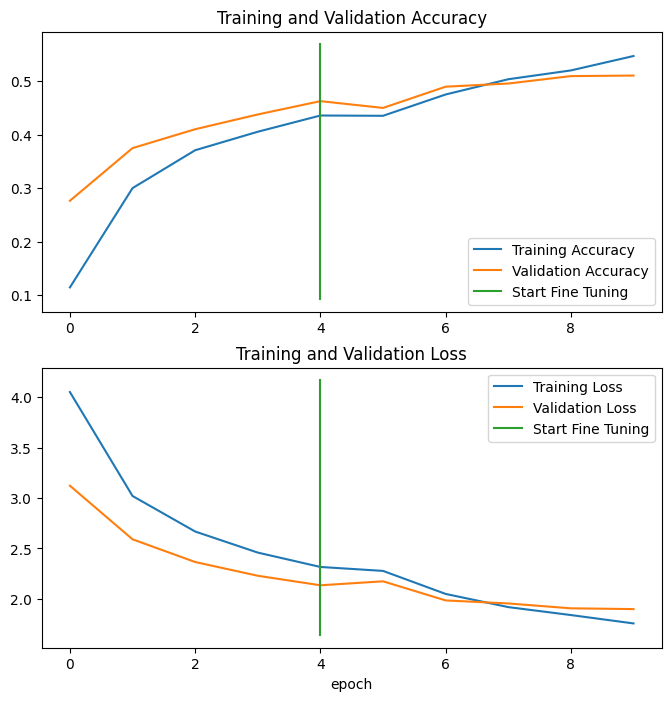

In [ ]:
compare_historys(original_history=history_0,
                 new_history=history_1,
                 initial_epochs=5)

### Saving this model

In [ ]:
import tensorflow as tf
from google.colab import drive
# drive.mount('/content/drive')
import os

# Create the directory if it doesn't exist
os.makedirs('/content/drive/MyDrive/tensorflow_course', exist_ok=True)

model.save('/content/drive/MyDrive/tensorflow_course/101_food_class_10_percent_model_1.keras')


In [ ]:
saved_model_path = '/content/drive/MyDrive/tensorflow_course/101_food_class_10_percent_model_1.keras'

model = tf.keras.models.load_model(saved_model_path)

In [ ]:
model.evaluate(test_data)

790/790 ━━━━━━━━━━━━━━━━━━━━ 48s 58ms/step - accuracy: 0.4624 - loss: 2.1037


[1.8990875482559204, 0.5104950666427612]